In [1]:
import os
import kagglehub
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Download dataset from KaggleHub
dataset_root = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
train_dir = os.path.join(dataset_root, "Training")
test_dir = os.path.join(dataset_root, "Testing")

In [4]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [5]:
# Load datasets
trainval_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
class_names = trainval_dataset.classes

In [6]:
# Split train into train/val
val_size = int(0.15 * len(trainval_dataset))
train_size = len(trainval_dataset) - val_size
train_dataset, val_dataset = random_split(trainval_dataset, [train_size, val_size])

In [7]:
# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, name, patience=5):
    best_acc = 0.0
    best_loss = float('inf')
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }
    early_stop_counter = 0

    for epoch in range(num_epochs):
        # ---------- Training ----------
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train

        # ---------- Validation ----------
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = correct_val / total_val

        # ---------- Logging ----------
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # ---------- Save best model ----------
        if val_loss < best_loss:
            best_loss = val_loss
            best_acc = val_acc
            torch.save(model.state_dict(), f"best_brain_tumor_{name}.pth")
            early_stop_counter = 0  # reset if improvement
        else:
            early_stop_counter += 1
            print(f"No improvement in validation loss for {early_stop_counter} epoch(s).")

        # ---------- Early stopping ----------
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

    return history


In [9]:
# Testing function
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = correct / total
    print(f"Test Accuracy: {acc:.4f}")


In [10]:
def visualize_predictions(model, loader, num_images=6):
    model.eval()
    images_shown = 0
    fig = plt.figure(figsize=(12, 6))

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for j in range(images.size(0)):
                if images_shown == num_images:
                    plt.tight_layout()
                    return

                ax = fig.add_subplot(2, num_images//2, images_shown + 1)
                img = images[j].cpu().permute(1, 2, 0).numpy()
                img = (img * 0.5 + 0.5).clip(0, 1)  # Unnormalize

                ax.imshow(img)
                true_label = class_names[labels[j]]
                pred_label = class_names[preds[j]]
                ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
                ax.axis('off')

                images_shown += 1

    plt.tight_layout()
    plt.show()

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
def evaluate_model(model, loader, class_names, title="Confusion Matrix"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification report
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()


In [12]:
model2 = models.efficientnet_b0(pretrained=True)

# Freeze all parameters
for param in model2.parameters():
    param.requires_grad = False

# Modify the classifier
num_ftrs = model2.classifier[1].in_features
model2.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 4)  # Assuming 4 output classes
)

model2 = model2.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 88.9MB/s]


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.classifier.parameters(), lr=0.001)
history = train_model(model2, train_loader, val_loader, criterion, optimizer, num_epochs=60, name='efficientnetb0')

Epoch [1/60] Train Loss: 0.4511, Train Acc: 0.8427 Val Loss: 0.2414, Val Acc: 0.9159
Epoch [2/60] Train Loss: 0.3000, Train Acc: 0.8952 Val Loss: 0.2122, Val Acc: 0.9171
Epoch [3/60] Train Loss: 0.2417, Train Acc: 0.9108 Val Loss: 0.1833, Val Acc: 0.9171
Epoch [4/60] Train Loss: 0.2099, Train Acc: 0.9257 Val Loss: 0.1926, Val Acc: 0.9147
No improvement in validation loss for 1 epoch(s).
Epoch [5/60] Train Loss: 0.1961, Train Acc: 0.9232 Val Loss: 0.1916, Val Acc: 0.9276
No improvement in validation loss for 2 epoch(s).
Epoch [6/60] Train Loss: 0.1697, Train Acc: 0.9386 Val Loss: 0.1561, Val Acc: 0.9381
Epoch [7/60] Train Loss: 0.1497, Train Acc: 0.9458 Val Loss: 0.1452, Val Acc: 0.9451
Epoch [8/60] Train Loss: 0.1460, Train Acc: 0.9454 Val Loss: 0.1440, Val Acc: 0.9428
Epoch [9/60] Train Loss: 0.1358, Train Acc: 0.9479 Val Loss: 0.1598, Val Acc: 0.9357
No improvement in validation loss for 1 epoch(s).
Epoch [10/60] Train Loss: 0.1255, Train Acc: 0.9543 Val Loss: 0.1470, Val Acc: 0.9428

Test Accuracy: 0.9703


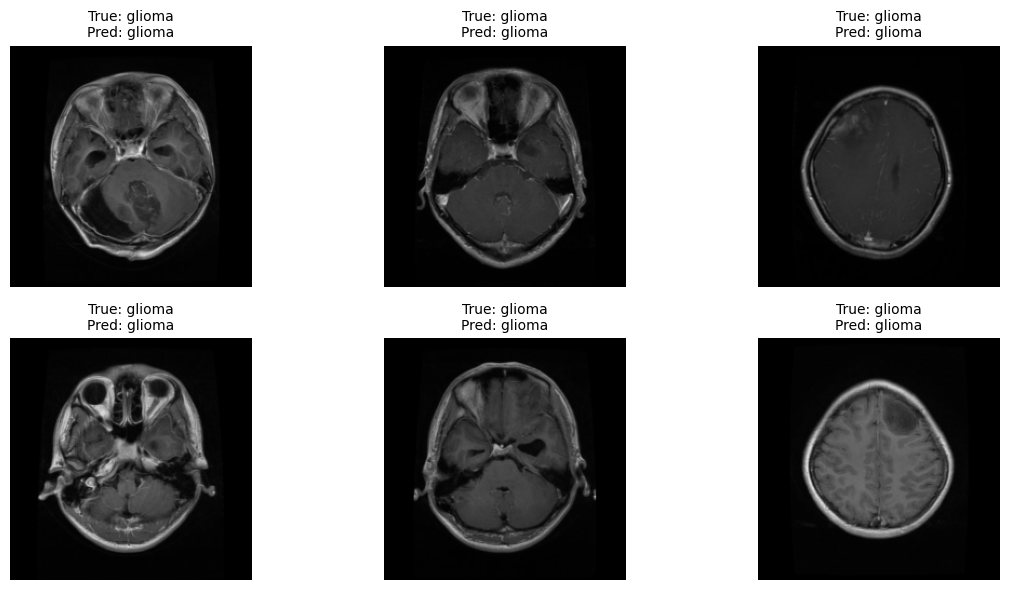

In [16]:
# First test
model2.load_state_dict(torch.load("best_brain_tumor_efficientnetb0.pth"))
test_model(model2, test_loader)
visualize_predictions(model2, test_loader, 6)


Evaluation: Initial efficientnetb0 Model
              precision    recall  f1-score   support

      glioma       0.96      0.92      0.94       300
  meningioma       0.92      0.97      0.94       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.99      0.99      0.99       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



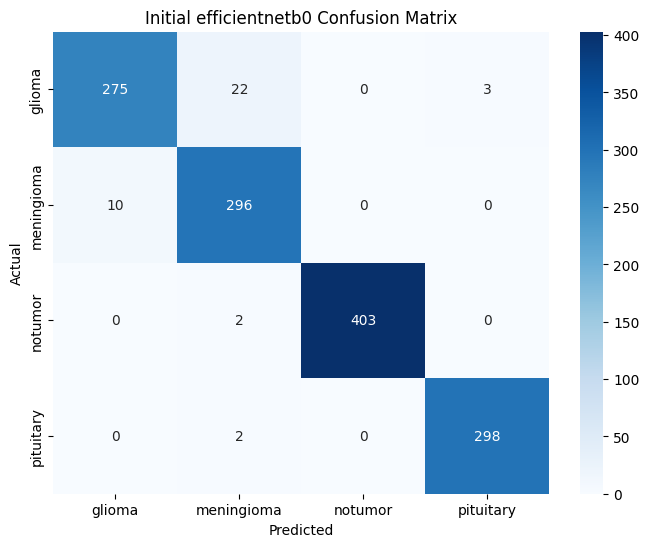

In [17]:
print("\nEvaluation: Initial efficientnetb0 Model")
model2.load_state_dict(torch.load("best_brain_tumor_efficientnetb0.pth"))
evaluate_model(model2, test_loader, class_names, title="Initial efficientnetb0 Confusion Matrix")


In [18]:
# Fine-tuning
for name, param in model2.named_parameters():
    if "layer3" in name or "layer4" in name or "fc" in name:
        param.requires_grad = True

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model2.parameters()), lr=1e-4)
history = train_model(model2, train_loader, val_loader, criterion, optimizer, num_epochs=60, name='efficientnetb0_finetuned')

Epoch [1/60] Train Loss: 0.0631, Train Acc: 0.9788 Val Loss: 0.1194, Val Acc: 0.9638
Epoch [2/60] Train Loss: 0.0533, Train Acc: 0.9833 Val Loss: 0.1181, Val Acc: 0.9614
Epoch [3/60] Train Loss: 0.0433, Train Acc: 0.9850 Val Loss: 0.1155, Val Acc: 0.9614
Epoch [4/60] Train Loss: 0.0453, Train Acc: 0.9866 Val Loss: 0.1117, Val Acc: 0.9626
Epoch [5/60] Train Loss: 0.0384, Train Acc: 0.9876 Val Loss: 0.1127, Val Acc: 0.9661
No improvement in validation loss for 1 epoch(s).
Epoch [6/60] Train Loss: 0.0392, Train Acc: 0.9883 Val Loss: 0.1034, Val Acc: 0.9650
Epoch [7/60] Train Loss: 0.0357, Train Acc: 0.9872 Val Loss: 0.1078, Val Acc: 0.9650
No improvement in validation loss for 1 epoch(s).
Epoch [8/60] Train Loss: 0.0316, Train Acc: 0.9905 Val Loss: 0.1133, Val Acc: 0.9673
No improvement in validation loss for 2 epoch(s).
Epoch [9/60] Train Loss: 0.0332, Train Acc: 0.9889 Val Loss: 0.1009, Val Acc: 0.9650
Epoch [10/60] Train Loss: 0.0242, Train Acc: 0.9926 Val Loss: 0.1090, Val Acc: 0.9650

Test Accuracy: 0.9779


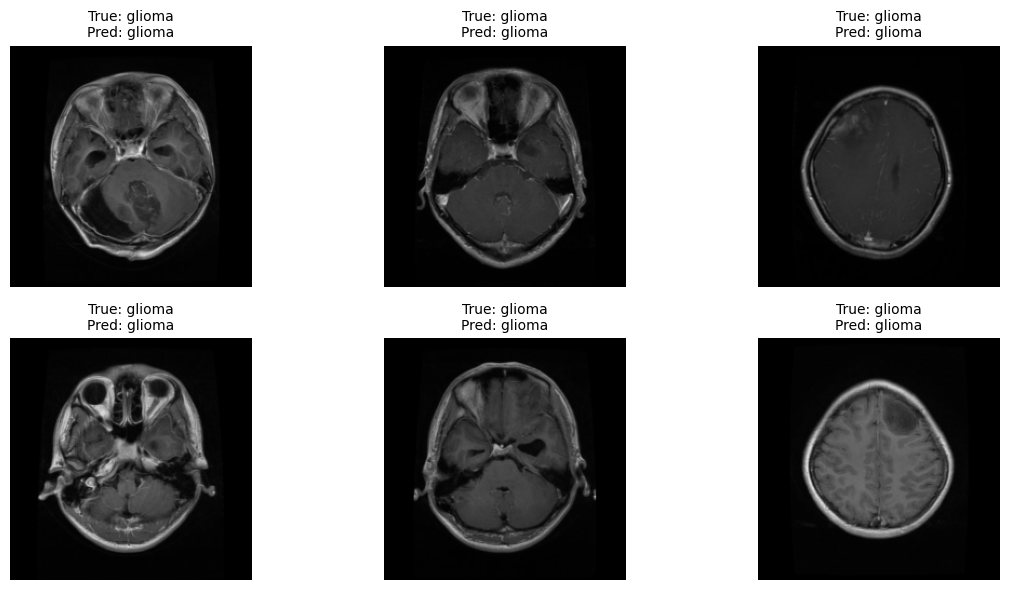

In [19]:
# Final test
model2.load_state_dict(torch.load("best_brain_tumor_efficientnetb0_finetuned.pth"))
test_model(model2, test_loader)
visualize_predictions(model2, test_loader, 6)


Evaluation: Fine-tuned efficientnetb0 Model
              precision    recall  f1-score   support

      glioma       0.99      0.93      0.96       300
  meningioma       0.93      0.98      0.96       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.99      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



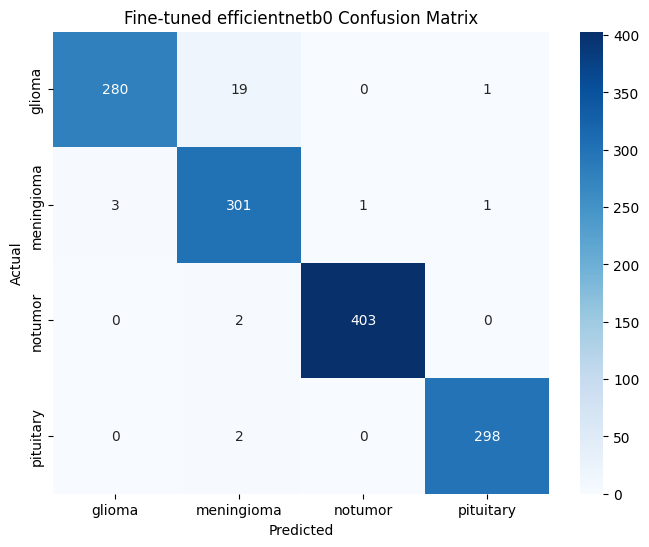

In [20]:
print("\nEvaluation: Fine-tuned efficientnetb0 Model")
model2.load_state_dict(torch.load("best_brain_tumor_efficientnetb0_finetuned.pth"))
evaluate_model(model2, test_loader, class_names, title="Fine-tuned efficientnetb0 Confusion Matrix")
